# Discrete Probability

## Motivation

**Context:** As your first assignment at IHH's ML team, you've been tasked with better understanding their Emergency Room (ER). Since you're new, you'd first like to better understand how the ER works at a high level. Specifically, you'd like to answer questions like:

* Q1: How many beings come to ER every day?
* Q2: Overall, what conditions do the beings come to the ER for? (e.g. inflamed antenna, fever, etc.)
* Q3: How many being remain hospitalized over night?

**Challenge:** The answer to both of these questions cannot be given by a single number (e.g. the number of beings that come to the ER changes from day to day). So how can we give a deterministic answer to a question whose response is inherently variable or *stochastic*? Answer: *probability distributions*. Probability distributions are the basic building block that we will use to build complex ML systems. 

**Outline:** 
1. Introduce and practice the concepts, terminology, and notation behind discrete probability distributions (continuous distributions will be covered next).
2. Answer the above questions using this new toolset.
3. Start to gain familiarity with two important Python libraries we will use throughout the semester: `Jax` and `NumPyro`.

## Terminology and Notation for Discrete Probability

As in the spirit of all Computer Science classes, if we want the help of a computer to solve a problem, we need a *language* to precisely specify what we want it to do. Today, we will introduce the language---terminology and notation---from statistics, and we will then translate it into code that a computer can run.

The terminology that we introduce here is slightly different from ones that you may have seen in a statistics class. The reason for this is that we're honing in on the minimal subset of terminology we need to describe a probabilistic ML model.

**Random Variable (RV):** A variable whose possible values are outcomes of a random phenomenon.
> Example: Let $N$ be an RV describing the number of beings that come into the ER on a given day.

**Sample:** A sample is a particular observation of the random phenomenon.
> Example: On Monday, we observed $N = 30$ (on Tuesday, this number will be different).

**Sample Space or Support:** The set of all possible values that an RV can take on. For discrete probability, this set must be countable (though this is not important for now).
> Example: The sample space for $N$ is the set $S = [0, \infty)$, since we can have any number from $0$ to $\infty$ (theoretically speaking) of beings come to the ER. 

**Probability Mass Function (PMF):** A function mapping the outcome of an RV to the probability with which it occurs. We can write the PMF as a mapping from the sample space to a number on the unit interval: $p: S \rightarrow [0, 1]$.
> Example: Let $p_N(\cdot)$ denote the PMF of $N$, where the dot represents an argument we have not specified. We denote the probability that $N$ takes on a specific value $n$ as follows: $p_N(n)$. If we were told that $p_N(5) = 0.1$, this means that the probability that exactly 5 beings came to the ER is 0.1 (or 10%).

PMFs has one notable property: the probability of all outcomes in the sample space must sum to 1.
> Example: Continuing with the above example, we have that $\sum\limits_{n \in [0, \infty)} p_N(n) = 1$.

**Independent, Identically Distributed (i.i.d):** We say a variable is i.i.d if different observations of the same phenomenon are independent (i.e. that do not affect one another) and if they follow the same PMF. For example, when we flip a coin, previous flips do not affect future flips (i.e. if the coin landed heads, it does not affect its probability of landing heads next), and every time we flip the coin, the probability of it landing heads is the same (so it's identically distributed).
> Example: We the notation $N \sim p_N(\cdot)$ signifies that, the number of beings coming to the ER is distributed according to distribution $p_N(\cdot)$, and that $N$ is sampled i.i.d.

**Summary of Notation:** 
* Let $R$ denote an RV.
* We denote the PMF of $R$ using $p_R(\cdot)$. Note that $p_R(\cdot)$ is a function that maps possible values $R$ can take on to probabilities (between 0 and 1).
* We call $p_R(r)$ the evaluation of the function at $r$: i.e. what's the probability that $R$ equals the specific value $r$?
* We write $R \sim p_R(\cdot)$ to denote that $R$ is sampled i.i.d from $p_R(\cdot)$.

## Getting Familiar with Useful Discrete Distributions

```{admonition} Exercise
Browse the Wikipedia pages for the following distributions:
* [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution)
* [Categorical](https://en.wikipedia.org/wiki/Categorical_distribution)
* [Binomial](https://en.wikipedia.org/wiki/Binomial_distribution)
* [Geometric](https://en.wikipedia.org/wiki/Geometric_distribution)
* [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution)

Then, for each distribution,
1. Describe a random phenomenon from everyday life that can be described using the distribution. 
2. Define a random variable for the phenomenon you described. Write the support and PMF for this random variable using the above notation.
3. Describe a setting of the distribution's parameters that makes sense for your specific phenomenon (and explain why it makes sense).

*Hint: On each Wikipedia page, there's a panel on the right side that summarizes the properties of the distribution (e.g. its support, PMF, example plots, etc.).*

We'll get you started with the Bernoulli distribution (and you can do the rest): 
1. The Bernoulli distribution models any random choice between two options. For example, it can model a coin flip. 
2. Let $H$ be the outcome of a random coin flip. Support: $H \in S = \{0, 1\}$, where 1 is heads and 0 is tails. PMF: $p_H(h) = \rho^h \cdot (1 - \rho)^{1 - h}$, where $h \in S$ and $0 \leq \rho \leq 1$. 
3. For a fair coin, $\rho = 0.5$, indicating that on average, half of all coin flips will result in heads and the other in tails.
```

TODO: write your response here.

## Matching the Distribution to the Scenario

We'll now start working with data from IHH's ER. We'll use a Python library called `pandas` to read in the data, which is stored as a `.csv` file:

In [1]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax
import jax.numpy as jnp

# Load in the data into a pandas dataframe
#csv_fname = 'https://raw.githubusercontent.com/mogu-lab/cs349-fall-2024/master/lectures/probability/IHH-ER.csv'
csv_fname = 'IHH-ER.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of 5 patients, just to see what's in the data
data.sample(10)

,Day-of-Week,Condition,Hospitalized,Antibiotics
Patient ID,,,,
822,Tuesday,Allergic Reaction,No,No
5051,Sunday,Allergic Reaction,No,No
9641,Wednesday,Broken Limb,No,No
2473,Friday,High Fever,Yes,No
8922,Saturday,Allergic Reaction,No,No
3953,Thursday,Broken Limb,No,No
5977,Tuesday,Intoxication,No,No
1824,Friday,Entangled Antennas,No,No
8923,Monday,High Fever,Yes,No


As you can see from the loaded data, each variable here can be used to answer each of the above questions (Q1-Q3).

```{admonition} Exercise
Use `pandas` and `matplotlib` to visualize the distribution of each variable. You may have to do some googling around to determine which library calls are appropriate for each variable.
```

We'll start you off by visualizing the distribution of the different conditions:

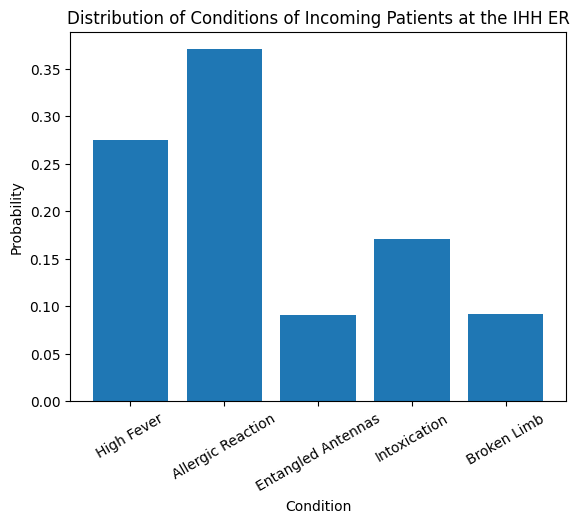

In [7]:
# Visualize the distribution of conditions at the IHH ER

# Compute the percentage of patients with each condition
counts = data['Condition'].value_counts(sort=False, normalize=True)

# Put the names of the variables in to x, and the percentage into y
x = []
y = []
for variable, probability in counts.items():
    x.append(variable)
    y.append(probability)

# Plot!
plt.bar(x, y)

# Add axis labels and titles
plt.xticks(rotation=30)
plt.xlabel('Condition')
plt.ylabel('Probability')
plt.title('Distribution of Conditions of Incoming Patients at the IHH ER')
plt.show()

In [3]:
# TODO: Visualize the distribution of the number of patients per day

In [4]:
# TODO: Visualize the distribution of whether patients were hospitalized or not

```{admonition} Exercise
1. Determine which distribution from the list above best matches each variable in the data. How did you decide which one to choose? Please justify your choice with the support and PMF of the distribution.
2. Are the matches you selected perfect? If not, how are they lacking?
3. What kind of information do we miss when considering each variable separately? For our ER data, are there variables you would recommend the IHH consider at jointly? Please back your recommendation up with evidence (i.e. plots).
```

TODO: write your answer here.